## 2) End-Host profile

Our initial findings indicate
that profiles can vary greatly across users and this motivates the use of end-host
profiles for security, diagnosis and classification applications. One of our interesting findings is that over short time scales (e.g., 15 minutes) the profiles evolve
slowly typically experiencing small changes, yet over longer periods of time (e.g.,
a month), the majority of the profile content may change. This indicates that
most parts of the profile are apt to change, and further underscores the need for
adaptivity.



We believe that graphlets are an interesting approach to end-host profiling for a
number of reasons. First, one could imagine keeping per host flow records in order
to compute statistics regarding its behavior. A database of flow records is an
enormous amount of information. Instead, our graphlet achieves a representation
of important information in a compact form limiting the redundancy. Second,
such flow records are not interpretable without further processing. However, the
paths, nodes and node properties in graphlets are easy to interpret.
We can further expand graphlets to annotate nodes with temporal information. For example, we can create time series information for each node (e.g., the
time series of the out-degree). This is equivalent to annotating the nodes in the
graph and tracking the evolution of the weights. Similarly, we can attach weights
to links in the graph in order to track more typical features, such as the number
of packets or bytes for all flows transiting that path. Existing security solutions
use threshold based-techniques on metrics like the number of TCP connections
per destination port per time interval. Recent solutions examine the dispersion
of the 3 key fields [6]. All such techniques can be captured within the framework
of weight-annotated graphlets. The power of this profiling mechanism is that it
goes beyond these methods, since it also incorporates the graph relationships,
all in a single structure. We illustrate this here with three examples:
• The out-degree of the TCP node (or any protocol node) reveals the typical
number of TCP destination IPs per client. By observing how the out-degree
of the TCP node in the graphlet evolves over time, we learn about the typical range for the number of simultaneous destinations contacted through TCP
within a window of time (the time scale of the graphlet). For example, Fig. 2
(left) presents a histogram of the average out-degree of the TCP node for all our
client graphlets every 15 minutes. We observe a wide range of behavior.
• For applications with well-known port numbers, graphlets can reveal what is
the typical number of destination IPs contacted for each given application. For
Profiling the End Host 191
Method: Construct Profile
1. Upon arrival of each packet, update
activity graphlet if flow information
not already included.
2. Every t minutes
a). identify new significant activity,
according to summarization policy
as candidate to join profile graphlet.
b). Add new significant activity into
profile, if approved by delayed-accept
policy, using Algorithm 1.
c). Remove stale parts of profile
according to aging policy.
Fig. 3. Summary of Method
Algorithm 1: Populate Profile Graphlet
with Significant Nodes
Repeat until all significant nodes
processed
1. Rank all nodes in activity
graphlet according to their maximum
in-degree or out-degree:
max{indegree,outdegree}
2. Remove the highest degree node
and all its edges. Insert into
profile graphlet.
Fig. 4. Algorithm: inserting significant nodes into profile
example, examining the out-degree of the graphlet node for destination “port
80” reveals the number of destinations typically contacted by an HTTP application. Similarly Fig. 2 (right) presents a histogram of the average out-degree
of the “port-80” node for all our client graphlets computed every 15 minutes.
Again we see considerable variability across hosts.
• Scanning behavior can be easily seen from graphlets. For example, port scanning would appear as an excessively large number of destination ports associated
with a single destination address. Similarly if a host initiates an address-space
scan for a specific port (worm-like behavior) this would appear as an excessively
large number of destination IPs associated with a single destination port.

In [66]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import math
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
import time 
from scipy.sparse import lil_matrix, kron,identity
from sklearn.model_selection import  train_test_split
from sklearn.metrics import accuracy_score,classification_report, confusion_matrix
from scipy.sparse.linalg import lsqr
from sklearn import svm, datasets

## 3) build the graphlets corresponding to the following network

In [4]:
d = {'srcIP': ["12.124.65.34","12.124.65.35","12.124.65.35","12.124.65.36"], 'dstIP': ["12.124.65.33","12.124.65.37","12.124.65.36","12.124.65.37"], 'protocol': ["17","17","6","6"],'sPort': ["138","80","167","443"],'dPort': ["138","80","80","443"],'activity': ["normal","normal","anomaly","anomaly"]}
dfClassified = pd.DataFrame(data=d)
dfClassified

,activity,dPort,dstIP,protocol,sPort,srcIP
0,normal,138,12.124.65.33,17,138,12.124.65.34
1,normal,80,12.124.65.37,17,80,12.124.65.35
2,anomaly,80,12.124.65.36,6,167,12.124.65.35
3,anomaly,443,12.124.65.37,6,443,12.124.65.36


In [5]:
def graphletEdges(df):
    E=[]
    for index, row in df.iterrows():
        E.append((row["srcIP"], row["protocol"]+" "))
        E.append((row["protocol"]+" ", " "+row["dstIP"]))
        E.append((" "+row["dstIP"], " "+row["sPort"]+" "))
        E.append((" "+row["sPort"]+" ", "  "+row["dPort"]+"  "))
        E.append(("  "+row["dPort"]+"  ", "  "+row["dstIP"]))  
    return E

In [6]:
def computeGraphlet(src,df):
    E=[]
    for index, row in df[df.srcIP==src].iterrows():
        E.append((row["srcIP"], row["protocol"]+" "))
        E.append((row["protocol"]+" ", " "+row["dstIP"]))
        E.append((" "+row["dstIP"], " "+row["sPort"]+" "))
        E.append((" "+row["sPort"]+" ", "  "+row["dPort"]+"  "))
        E.append(("  "+row["dPort"]+"  ", "  "+row["dstIP"])) 
    G = nx.DiGraph()
    G.add_edges_from(E)
    return G

In [7]:
def anomalGraphletEdges(df):
    anomalE=[]
    for index, row in df.iterrows():
        if row["activity"] =="anomaly":
            anomalE.append((row["srcIP"], row["protocol"]+" "))
            anomalE.append((row["protocol"]+" ", " "+row["dstIP"]))
            anomalE.append((" "+row["dstIP"], " "+row["sPort"]+" "))
            anomalE.append((" "+row["sPort"]+" ", "  "+row["dPort"]+"  "))
            anomalE.append(("  "+row["dPort"]+"  ", "  "+row["dstIP"]))  
    return anomalE

In [8]:
def plotGraflet(graphlet):
    E=graphletEdges(graphlet)
    anomalE=anomalGraphletEdges(graphlet)
    G = nx.DiGraph()
    G.add_edges_from(E)
    pos = graphviz_layout(G, prog='dot')
    nx.draw(G,pos,with_labels = True,node_color="skyblue", linewidths=2,node_size=700,alpha=0.9)
    nx.draw_networkx_edges(G, pos, edgelist=anomalE,width=8, alpha=0.4, edge_color='r')
    plt.show()

In [9]:
def plotMultipleGraflet(df):
    for i in range(len(df.srcIP.unique())):
        graphletDF = df[df.srcIP==df.srcIP.unique()[i]]
        fig= plt.figure(figsize=(7, 7))
        plotGraflet(graphletDF)


In [10]:
def dfFromSources(srcArray,df):
    dfArray=[]
    for i in srcArray:
        dfArray.append(df[df.srcIP==i])
    return pd.concat(dfArray)

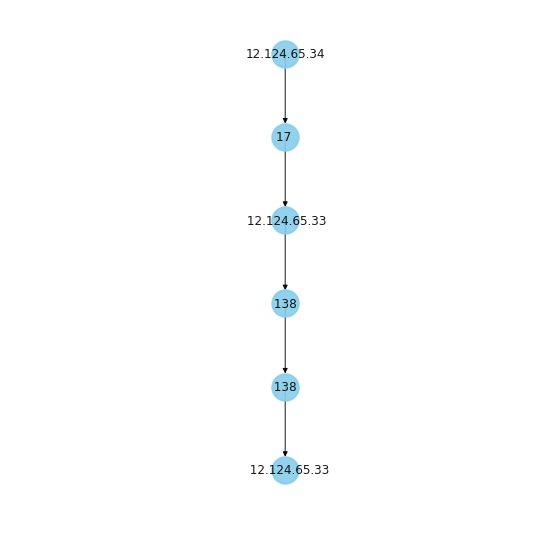

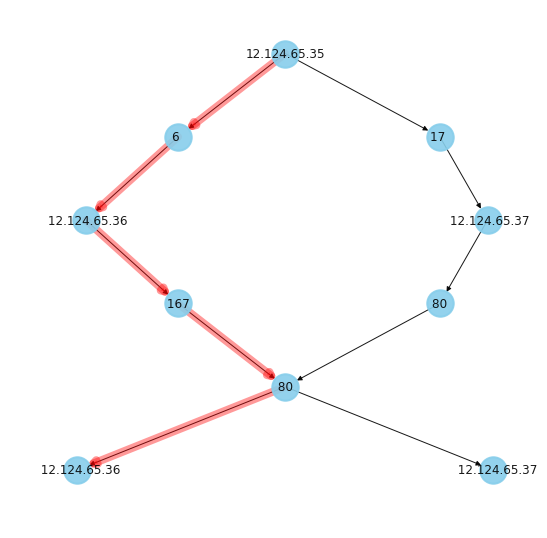

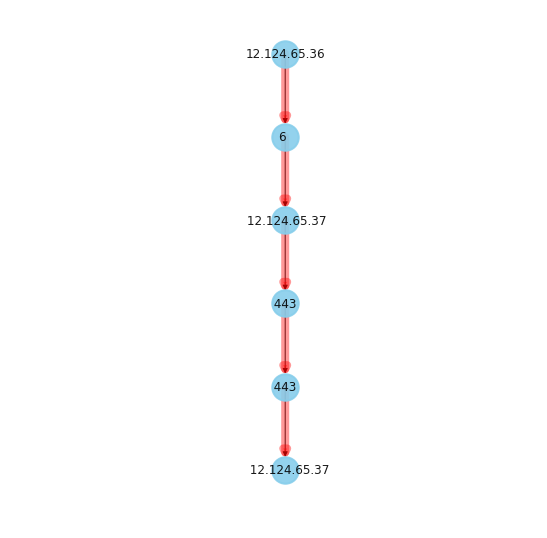

In [11]:
plotMultipleGraflet(dfClassified)

In [12]:
dfClassified = pd.read_csv('annotated-trace.csv').astype(str)
dfClassified

,srcIP,dstIP,protocol,sPort,dPort,activity
0,214,776,17,21,79,normal
1,933,79,6,21,80,normal
2,139,243,17,53,80,normal
3,920,198,6,80,21,normal
4,100,174,17,20,21,normal
5,756,435,17,80,79,normal
6,669,409,6,53,80,normal
7,518,57,6,68,23,normal
8,785,389,17,22,68,normal
9,485,657,17,25,21,normal


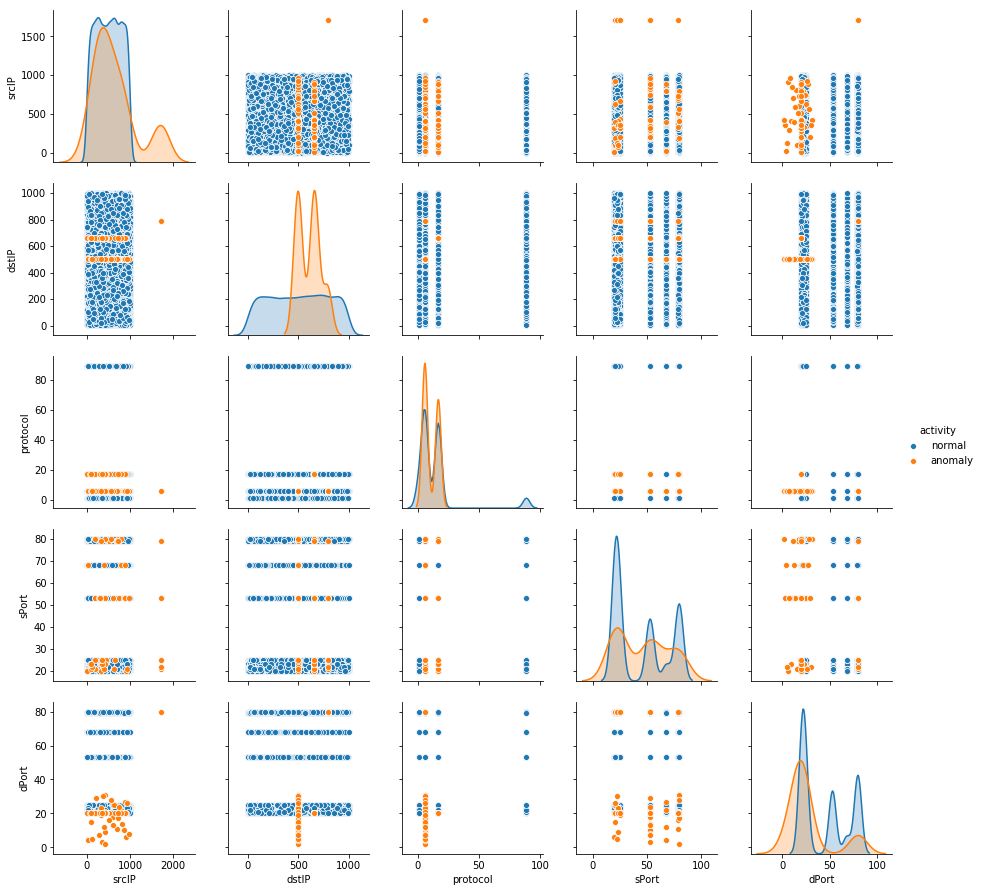

In [13]:
sns.pairplot(dfClassified, kind="scatter", hue="activity")
plt.show()

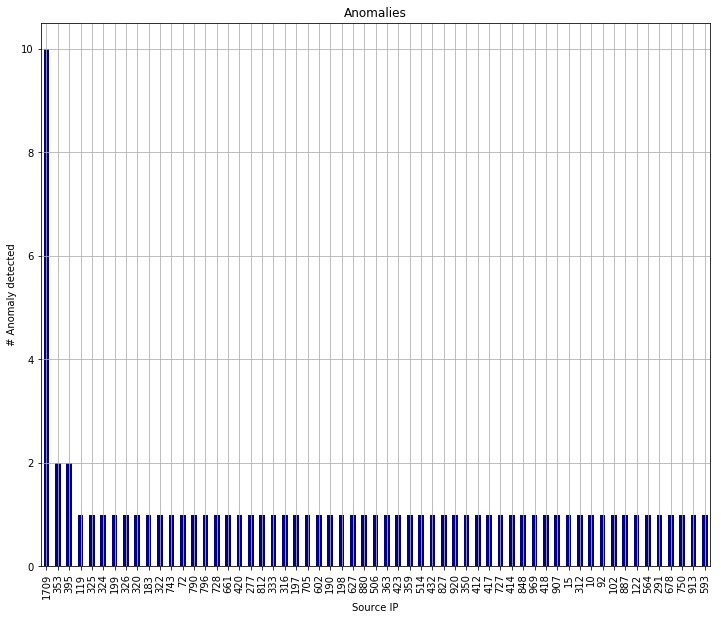

In [14]:
dfClassified[dfClassified.activity=="anomaly"]
ax = dfClassified[dfClassified.activity=="anomaly"].srcIP.value_counts().plot(kind="bar", figsize=(12, 10),colormap='jet',title='Anomalies',grid=True)
ax.set_xlabel("Source IP")
ax.set_ylabel("# Anomaly detected")



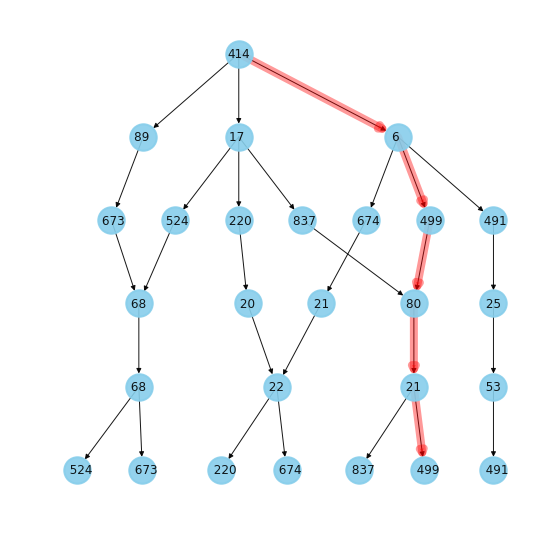

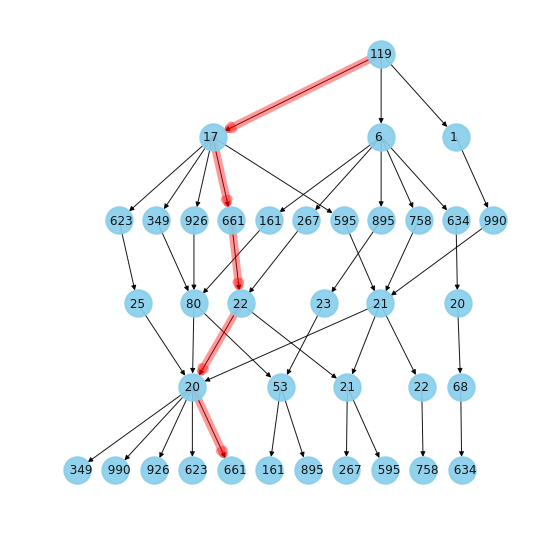

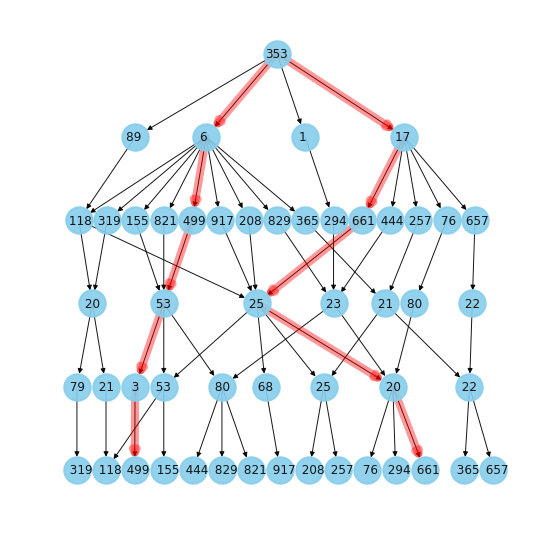

In [15]:
sources = ["414","119","353"]
plotMultipleGraflet(dfFromSources(sources,dfClassified))

In [16]:
def nAnomalies(src,df):
    graph=df[df.srcIP==src]
    return len(graph[graph.activity=="anomaly"])

In [17]:
def computeFeatureVector(walkLength,graphlet):
    a=nx.adjacency_matrix(graphlet).todense()
    i=np.identity(a.shape[0], dtype = int )
    b=a
    res=i+a
    for i in range(1,walkLength):
        a=np.dot(a,b)
        res+=a
    return np.squeeze(np.asarray(res)).flatten()

In [18]:
def computeGraphlet2(src,df):
    E=[]
    for index, row in df[df.srcIP==src].iterrows():
        E.append((row["srcIP"], row["protocol"]))
        E.append((row["protocol"],row["dstIP"]))
        E.append((row["dstIP"],row["sPort"]))
        E.append((row["sPort"],row["dPort"],))
        E.append((row["dPort"],row["dstIP"])) 
    G = nx.DiGraph()
    G.add_edges_from(E)
    return G

## Random Walk

In [102]:
graphlets = []
Y=[]
features = []
maxlen=0
srcIP = list(dfClassified.srcIP.unique())
for i in range(len(srcIP)):
    graphlets.append(computeGraphlet2(srcIP[i],dfClassified))
    features.append(computeFeatureVector(4,graphlets[i]))
    if (len(features[i]) > maxlen):
            maxlen=len(features[i]) 
    if (nAnomalies(srcIP[i],dfClassified) != 0):
        Y.append("anomaly")
    else:
        Y.append("normal")
for i in range(len(srcIP)):
    features[i]=np.squeeze(np.resize(features[i],(1,maxlen)))   

1225


In [20]:
X_train, X_test, y_train, y_test = train_test_split(features, Y, test_size=0.2,random_state=0) 
clf = svm.SVC(gamma='auto',kernel='poly')
clf.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='poly',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [21]:
y_pred= clf.predict(X_test) # Predicting the classes of testing entries
print accuracy_score(y_test,y_pred)

0.8606965174129353


              precision    recall  f1-score   support

     anomaly       0.11      0.15      0.12        13
      normal       0.94      0.91      0.92       188

   micro avg       0.86      0.86      0.86       201
   macro avg       0.52      0.53      0.52       201
weighted avg       0.89      0.86      0.87       201



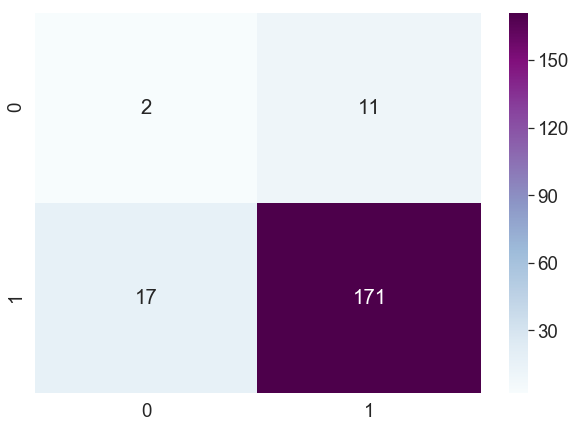

In [22]:
print classification_report(y_test, y_pred) # Printing the accuracy comparing the true classes with the predicted ones for each class

# Creating the confusion matrix and visualize it
cm=confusion_matrix(y_test, y_pred,labels=['anomaly', 'normal'])
df_cm = pd.DataFrame(cm, range(2),range(2))
plt.figure(figsize = (10,7))
sns.set(font_scale=1.7)
sns.heatmap(df_cm, annot=True, fmt='g',cmap="BuPu")

In [23]:
clf = svm.SVC(gamma='auto',kernel='linear')
clf.fit(features, Y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [24]:
graphlets = []
featuresUnclassified = []
dfUnclassified = pd.read_csv('not-annotated-trace.csv').astype(str)
srcIP = list(dfUnclassified.srcIP.unique())
for i in range(len(srcIP)):
    graphlets.append(computeGraphlet2(srcIP[i],dfUnclassified))
    featuresUnclassified.append(computeFeatureVector(4,graphlets[i]))
for i in range(len(srcIP)):
    featuresUnclassified[i]=np.squeeze(np.resize(featuresUnclassified[i],(1,maxlen)))

In [25]:
y_pred= clf.predict(featuresUnclassified)
predictions = pd.DataFrame({'srcIP':srcIP,'activity':y_pred})
predictions[predictions.activity=="anomaly"]

,activity,srcIP
0,anomaly,881
6,anomaly,219
112,anomaly,40
142,anomaly,787
229,anomaly,969
297,anomaly,871
329,anomaly,952
334,anomaly,56
359,anomaly,228
393,anomaly,698


## Kernel Trick

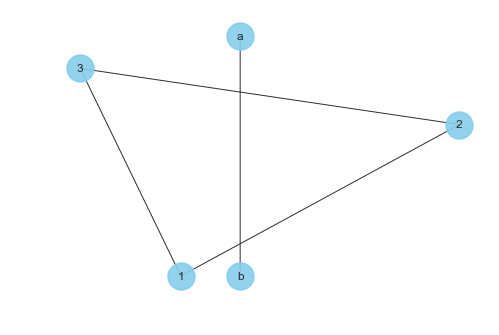

In [26]:
G1 = nx.Graph()
G1.add_edges_from([(1,2),(2,3),(1,3)])
G2 = nx.Graph()
G2.add_edges_from([('a','b')])
nx.draw(G1,with_labels = True,node_color="skyblue", linewidths=2,node_size=700,alpha=0.9)
nx.draw(G2,with_labels = True,node_color="skyblue", linewidths=2,node_size=700,alpha=0.9)

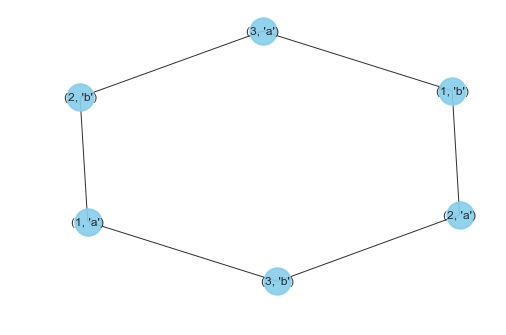

In [27]:
G=nx.tensor_product(G1, G2)
nx.draw(G,with_labels = True,node_color="skyblue", linewidths=2,node_size=700,alpha=0.9)

In [28]:
def randomWalkKernelTrick(G, H):
    LAMBDA = 0.1
    productGraph = nx.tensor_product(G,H)
    a=nx.adjacency_matrix(productGraph).todense()
    print a
    i=np.identity(a.shape[0], dtype = int )
    res=np.linalg.inv(i-LAMBDA*a).sum()
    return res

In [29]:
randomWalkKernelTrick(G1, G2)

[[0 0 1 1 0 0]
 [0 0 0 1 0 1]
 [1 0 0 0 1 0]
 [1 1 0 0 0 0]
 [0 0 1 0 0 1]
 [0 1 0 0 1 0]]


7.500000000000002

In [30]:
def randomWalkKernelTrick(Ax, Ay):
    Az = np.kron(Ax,Ay)
    LAMBDA = 0.1
    print Az
    G = nx.from_numpy_matrix(Az)
    nx.draw(G,with_labels = True,node_color="skyblue", linewidths=2,node_size=700,alpha=0.9)
    i=np.identity(Az.shape[0], dtype = int )
    res=np.linalg.inv(i-LAMBDA*Az).sum()
    return res

[[0 0 0 1 0 1]
 [0 0 1 0 1 0]
 [0 1 0 0 0 1]
 [1 0 0 0 1 0]
 [0 1 0 1 0 0]
 [1 0 1 0 0 0]]


7.500000000000002

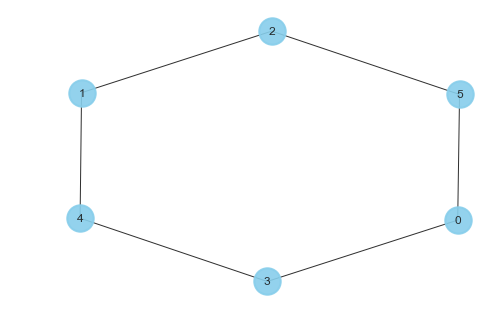

In [31]:
Ax=nx.adjacency_matrix(G1).todense()
Ay=nx.adjacency_matrix(G2).todense()
randomWalkKernelTrick(Ax, Ay)

In [229]:
def randomWalkKernelTrick(Ax, Ay):
    res = []
    for i in range(len(Ax)):
        temp=[]
        A1 = Ax[i][Ax[i] != -1]
        A1 = A1.reshape(int(math.sqrt(A1.size)),int(math.sqrt(A1.size)))
        for j in range(len(Ay)):              
            A2 = Ay[j][Ay[j] != -1]            
            A2 = A2.reshape(int(math.sqrt(A2.size)),int(math.sqrt(A2.size)))
            Az = np.kron(A1,A2)
            LAMBDA = 0.1
            i=np.identity(Az.shape[0], dtype = int )
            temp.append(np.linalg.inv(i-LAMBDA*Az).sum())
        res.append(temp)
        print len(res)
    return res

In [160]:
Ax=np.squeeze(np.array(nx.adjacency_matrix(G1).todense().flatten()))
Ay=np.squeeze(np.array(nx.adjacency_matrix(G2).todense().flatten()))
np.pad(Ay, (0,Ax.size-Ay.size), 'constant', constant_values=(-1))
randomWalkKernelTrick(Ax, Ay)

IndexError: invalid index to scalar variable.

In [180]:
graphlets = []
Y=[]
features = []
maxlen=0
srcIP = list(dfClassified.srcIP.unique())
for i in range(len(srcIP)):
    graphlets.append(computeGraphlet2(srcIP[i],dfClassified))
    features.append(computeFeatureVector(4,graphlets[i]))
    if (len(features[i]) > maxlen):
            maxlen=len(features[i]) 
    if (nAnomalies(srcIP[i],dfClassified) != 0):
        Y.append("anomaly")
    else:
        Y.append("normal")
for i in range(len(srcIP)):
    features[i] = np.pad(features[i], (0,maxlen-features[i].size), 'constant', constant_values=(-1))

In [246]:
clf = svm.SVC(gamma='auto',kernel=randomWalkKernelTrick)
clf.fit(features[:70], Y[:70])

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto',
  kernel=<function randomWalkKernelTrick at 0x12266d0c8>, max_iter=-1,
  probability=False, random_state=None, shrinking=True, tol=0.001,
  verbose=False)

In [249]:
y_pred= clf.predict(features[:60])
predictions = pd.DataFrame({'srcIP':srcIP[:60],'activity':y_pred})
predictions[predictions.activity=="anomaly"]

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60


,activity,srcIP
5,anomaly,756
8,anomaly,785
16,anomaly,226


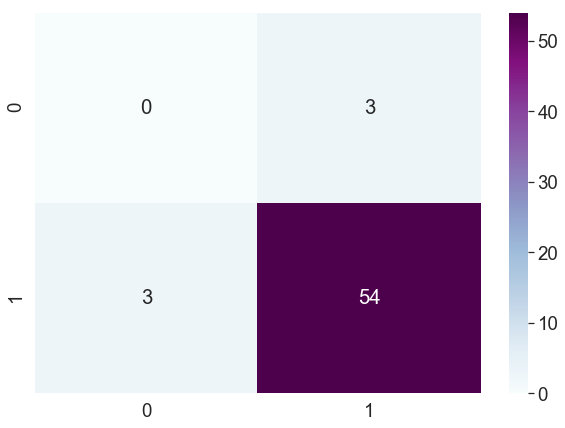

In [251]:
cm=confusion_matrix(Y[:60], y_pred,labels=['anomaly', 'normal'])
df_cm = pd.DataFrame(cm, range(2),range(2))
plt.figure(figsize = (10,7))
sns.set(font_scale=1.7)
sns.heatmap(df_cm, annot=True, fmt='g',cmap="BuPu")